In [763]:
import json
import random
import networkx as nx


with open("./data/zones.json") as f:
    zones_data = json.load(f)

with open("./data/crops.json") as f:
    crops_data = json.load(f)

with open("./data/climate_profiles.json") as f:
    climate_data = json.load(f)

with open("./data/soil_moisture_profiles.json") as f:
    soil_moisture = json.load(f)



In [764]:
class Zone:
    def __init__(self, zone_id, data, climate_profile, soil_moisture):

        self.id = zone_id
        self.name = data["name"]
        self.soil_types = data["soil_types"]
        self.dominant_soil = data["dominant_soil"]
        self.viable_crops = data["viable_crops"]
        self.agriculture_type = data["agriculture_type"]

        self.climate_profile = climate_profile

        # Soil moisture correctly extracted here
        sm_data = soil_moisture["zones"][zone_id]
        self.mean_sm = sm_data["mean"]
        self.std_sm = sm_data["std"]

        self.shared_crop_yield = {}
        self.shared_crop_profit = {}


    

In [765]:
from mesa import Agent
from mesa import Model
from mesa.agent import AgentSet

class FarmerAgent(Agent):
           
    def __init__(self, model, unique_id, zone, land_size, strategy_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.zone = zone
        self.model = model 
        self.land_size = land_size
        self.strategy_type = strategy_type  #"INDIVIDUAL" or "SHARED"
        self.memory = []  
        self.chosen_crop = None
        self.yield_t_ha = None  #yield in tons per hectare
        self.profit = 0

    def step(self):
        self.decide_crop()
        self.compute_yield()

        

    def decide_crop(self):
        zone = self.zone
        # Compute crop suitability scores (ecological baseline for ALL agents)
        suitability_scores = {}
        for crop in zone.viable_crops:
            suitability_scores[crop] = self.compute_suitability(crop)
        
        if self.strategy_type == "SHARED":
            # --- SHARED: additive bonus from cooperative zone knowledge ---
            # Shared knowledge BOOSTS scores of crops that performed well,
            # but does NOT override the ecological suitability baseline.
            if zone.shared_crop_yield:
                max_shared = max(zone.shared_crop_yield.values(), default=1)
                for crop in suitability_scores:
                    if crop in zone.shared_crop_yield and max_shared > 0:
                        shared_signal = zone.shared_crop_yield[crop] / max_shared
                        # Additive bonus: up to +0.15 for best-performing shared crop
                        suitability_scores[crop] += 0.15 * shared_signal

            # --- SHARED: additive bonus from network neighbors ---
            neighbor_bonus = {}  # accumulate per-crop bonus, then cap it
            neighbors = list(self.model.network.neighbors(self.unique_id))
            for neighbor_id in neighbors:
                neighbor = self.model.network.nodes[neighbor_id]["agent"]
                if neighbor.chosen_crop and neighbor.yield_t_ha is not None:
                    edge_weight = self.model.network[self.unique_id][neighbor_id].get("weight", 1.0)
                    max_yield = max([a.yield_t_ha for a in self.model.farmers if a.yield_t_ha is not None], default=1)
                    normalized_yield = neighbor.yield_t_ha / max_yield if max_yield > 0 else 0
                    if neighbor.chosen_crop in suitability_scores:
                        neighbor_bonus.setdefault(neighbor.chosen_crop, 0.0)
                        neighbor_bonus[neighbor.chosen_crop] += 0.05 * edge_weight * normalized_yield
            
            # Cap total neighbor influence per crop to avoid herding
            for crop, bonus in neighbor_bonus.items():
                suitability_scores[crop] += min(bonus, 0.10)  # cap at +0.10

            # --- SHARED: learn from own memory ---
            if self.memory:
                last = self.memory[-1]
                if last["crop"] in suitability_scores:
                    base = crops_data["crops"][last["crop"]]["base_yield_t_ha"]
                    ratio = last["yield"] / base if base > 0 else 0
                    suitability_scores[last["crop"]] += 0.05 * (ratio - 0.5)

        else:
            # --- INDIVIDUAL: no social learning, only own trial-and-error ---
            if self.memory:
                last = self.memory[-1]
                if last["crop"] in suitability_scores:
                    base = crops_data["crops"][last["crop"]]["base_yield_t_ha"]
                    ratio = last["yield"] / base if base > 0 else 0
                    suitability_scores[last["crop"]] += 0.05 * (ratio - 0.5)
        
        # Choose crop with highest score
        self.chosen_crop = max(suitability_scores, key=suitability_scores.get)

    def compute_suitability(self, crop_name):
        """
        compute suitability of a crop for the farmer's land based on:
        - Ecological zone compatibility
        - Soil type compatibility
        - Soil moisture suitability
        - Climate (temperature and precipitation) suitability
        """
        crop = crops_data["crops"][crop_name]
        zone = self.zone
        score = 0.0
        weight_total = 0.0 

        #### Zone compatibility (we can edit the weights later and score's contribution later) 
        zone_weight = 0.4  # how important is zone match
        if zone.id in crop["ideal_zones"]:
            score += 1.0 * zone_weight
        else:
            score += 0.5 * zone_weight  
        weight_total += zone_weight  # normalize the final score so that it always falls between 0 and 1

        #### soil type compatibility
        soil_weight = 0.3
        if zone.dominant_soil in crop["ideal_soils"]:
            soil_score = 1.0
        else:
            soil_score = 0.5 if any(s in crop["ideal_soils"] for s in zone.soil_types) else 0.0
        score += soil_score * soil_weight
        weight_total += soil_weight

        #### climate suitability (temperature and precipitation)
        climate_weight = 0.3
        climate_score = 0.0
        months = zone.climate_profile["monthly_climatology"]
        temp_score = 0.0
        precip_score = 0.0
        annual_precip = 0.0


        for month, data in months.items():

            t2m = data.get("T2M")
            prectot = data.get("PRECTOTCORR")
            if t2m is None or prectot is None:
                raise ValueError(f"Missing T2M or PRECTOTCORR for month {month} in zone {self.zone.id}")

            
            
            # Temperature
            t_mean = t2m["mean"]
            t_opt_min = crop["ecocrop"]["temp_opt_min_C"] 
            t_opt_max = crop["ecocrop"]["temp_opt_max_C"]
            t_abs_min = crop["ecocrop"]["temp_abs_min_C"]
            t_abs_max = crop["ecocrop"]["temp_abs_max_C"]

            if t_opt_min <= t_mean <= t_opt_max:
                temp_score += 1.0
            elif t_abs_min <= t_mean <= t_abs_max:
                temp_score += 0.5
            else:
                temp_score += 0.0

            # Precipitation
            p_mean = prectot["mean"] * 30
            p_opt_min = crop["ecocrop"]["precip_opt_min_mm"]
            p_opt_max = crop["ecocrop"]["precip_opt_max_mm"]
            p_abs_min = crop["ecocrop"]["precip_abs_min_mm"]
            p_abs_max = crop["ecocrop"]["precip_abs_max_mm"]
            annual_precip += p_mean


            if p_opt_min <= p_mean <= p_opt_max:
                precip_score += 1.0
            elif p_abs_min <= p_mean <= p_abs_max:
                precip_score += 0.5
            else:
                precip_score += 0.0

        # Normalize by number of months
        temp_score /= 12
        precip_score /= 12
        climate_score = 0.5*temp_score + 0.5*precip_score  
        score += climate_score * climate_weight
        weight_total += climate_weight

        #### Final suitability score normalized to [0,1]
        suitability = score / weight_total  
        return suitability

    def compute_yield(self):
        # Base yield * suitability (simplified)
        base_yield = crops_data["crops"][self.chosen_crop]["base_yield_t_ha"]
        # For now, yield is base yield adjusted by land size and randomness
        suitability = self.compute_suitability(self.chosen_crop)
        self.yield_t_ha = base_yield * suitability * (0.8 + 0.4 * random.random())
        self.profit = self.yield_t_ha * self.land_size  
        self.memory.append({"crop": self.chosen_crop, "yield": self.yield_t_ha, "profit": self.profit})

In [766]:
class FarmModel(Model):
    def __init__(self, zones_data, climate_data, crops_data, soil_moisture, n_agents):
        super().__init__()

        self.crops_data = crops_data
        self.zones = {}

        for zone_id, zone_info in zones_data["zones"].items():
            climate_profile = climate_data["zones"][zone_id]["climate_profile"]
            self.zones[zone_id] = Zone(
                zone_id,
                zone_info,
                climate_profile,
                soil_moisture
            )
        
        agents_list = []
        for i in range(n_agents):
            zone = random.choice(list(self.zones.values()))
            land_size = random.uniform(1, 10)
            strategy_type = random.choice(["SHARED", "INDIVIDUAL"])
            agent = FarmerAgent(
                model=self,           
                unique_id=i,          
                zone=zone,
                land_size=land_size,
                strategy_type=strategy_type
            )
            agents_list.append(agent)

        
        self.farmers = AgentSet(agents_list)

        self.network = nx.Graph()
        k = 4
        zone_agents = {}
        for agent in self.farmers:
            self.network.add_node(agent.unique_id, agent=agent)
            zone_agents.setdefault(agent.zone, []).append(agent)
        
        for agents_in_zone in zone_agents.values():
            for agent in agents_in_zone:
                peers = [a for a in agents_in_zone if a.unique_id != agent.unique_id]
                chosen = random.sample(peers, min(k, len(peers)))
                for peer in chosen:
                    self.network.add_edge(agent.unique_id, peer.unique_id, weight=random.uniform(0.5, 1.0))

        


    def step(self):
        self.farmers.shuffle_do("step")
        self.update_shared_knowledge()

    
    def update_shared_knowledge(self):
        for zone in self.zones.values():

            shared_agents = [
                a for a in self.farmers
                if a.zone == zone
                and a.strategy_type == "SHARED"
                and a.chosen_crop is not None
                and a.yield_t_ha is not None
            ]

            if not shared_agents:
                zone.shared_crop_yield = {}
                zone.shared_crop_yield_norm = {}
                continue

            crop_stats = {}

            for agent in shared_agents:
                crop_stats.setdefault(agent.chosen_crop, []).append(agent.yield_t_ha)

            # Average yield per crop
            zone.shared_crop_yield = {
                crop: sum(yields) / len(yields)
                for crop, yields in crop_stats.items()
            }

            # Normalize to [0,1] for easier use in decision function
            max_yield = max(zone.shared_crop_yield.values(), default=1)

            zone.shared_crop_yield_norm = {
                crop: (yield_val / max_yield if max_yield > 0 else 0)
                for crop, yield_val in zone.shared_crop_yield.items()
            }


In [767]:
model = FarmModel(zones_data, climate_data, crops_data, soil_moisture, 100)
for t in range(7):
    model.step()

# # Print each agent's results
# for agent in model.agents:
#     print(
#         agent.unique_id,
#         agent.strategy_type,
#         agent.zone.id,
#         agent.memory,
#         round(agent.yield_t_ha, 2),
#         round(agent.profit, 2)
#     )





mean_yield                                                     \
                count      mean        std       min       25%       50%   
strategy                                                                   
INDIVIDUAL       59.0  4.243757   8.985554  0.574089  0.664169  1.083145   
SHARED           41.0  8.773661  14.005048  0.606095  0.680071  1.229474   

                                mean_profit                                   \
                 75%        max       count       mean         std       min   
strategy                                                                       
INDIVIDUAL  3.319293  38.114483        59.0  25.819825   65.881744  1.155875   
SHARED      5.690218  39.653622        41.0  54.682917  101.397038  1.136563   

                                                       
                 25%       50%        75%         max  
strategy                                               
INDIVIDUAL  3.620206  5.672119  12.864693  354.649152  
SHARED      4.060713  5.743396  41.567809  364.031050

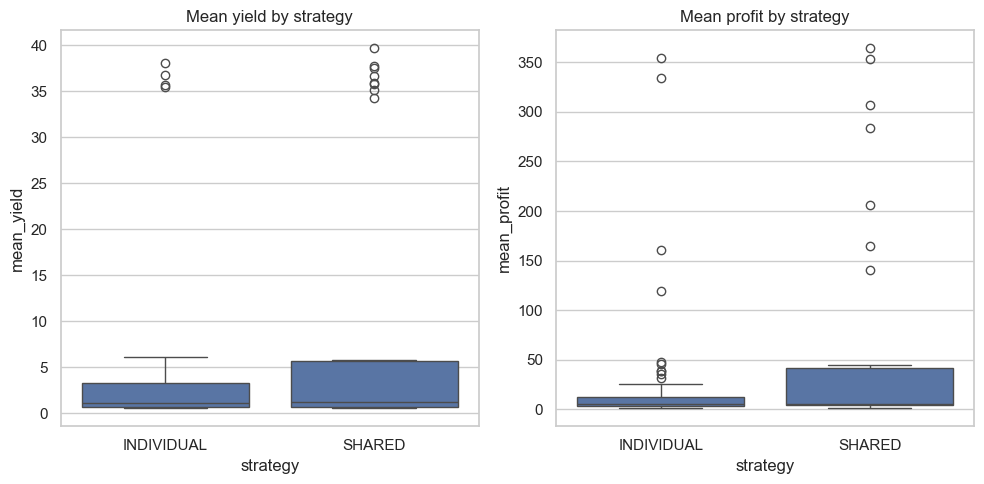

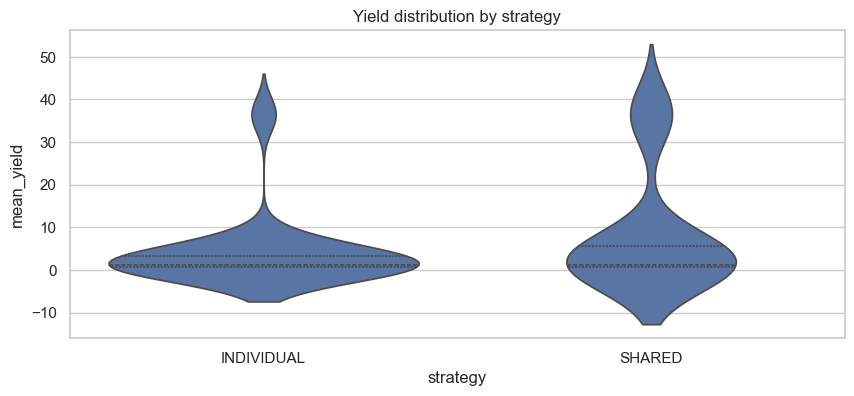

<Figure size 640x480 with 0 Axes>

In [768]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    sns = None

# Collect per-agent summary (mean yield and mean profit)
rows = []
agents = getattr(model, 'farmers', None) or getattr(model, 'agents', None) or []
for a in agents:
    mem = getattr(a, 'memory', [])
    if not mem:
        continue
    yields = [m['yield'] for m in mem if 'yield' in m]
    profits = [m['profit'] for m in mem if 'profit' in m]
    rows.append({
        'unique_id': getattr(a, 'unique_id', None),
        'strategy': getattr(a, 'strategy_type', None),
        'zone': getattr(getattr(a, 'zone', None), 'id', None),
        'mean_yield': sum(yields)/len(yields) if yields else None,
        'mean_profit': sum(profits)/len(profits) if profits else None,
        'yields': yields,
        'profits': profits,
    })

df = pd.DataFrame(rows)
display(df.groupby('strategy')[['mean_yield','mean_profit']].describe())

plt.figure(figsize=(10,5))
if sns is not None:
    plt.subplot(1,2,1)
    sns.boxplot(x='strategy', y='mean_yield', data=df)
    plt.title('Mean yield by strategy')
    plt.subplot(1,2,2)
    sns.boxplot(x='strategy', y='mean_profit', data=df)
    plt.title('Mean profit by strategy')
else:
    df.boxplot(column='mean_yield', by='strategy', rot=45, grid=False, figsize=(5,4))
    plt.title('Mean yield by strategy')
    plt.suptitle('')
    plt.show()

plt.tight_layout()
plt.show()

# Optional: violin for distribution if seaborn available
plt.figure(figsize=(10,4))
if sns is not None:
    sns.violinplot(x='strategy', y='mean_yield', data=df, inner='quartile')
    plt.title('Yield distribution by strategy')
    plt.show()

# Save summarized plot
plt.savefig('strategy_yield_profit_boxplots.png')